#### Install and import Python libraries

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import time
import gif
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from mot.data.data_track import MOT16Sequences
from mot.data.data_obj_detect import MOT16ObjDetect
from mot.models.object_detector import FRCNN_FPN
from mot.tracker.advanced import MPNTracker
from mot.eval import evaluate_mot_accums, get_mot_accum, evaluate_obj_detect
from mot.models.gnn import BipartiteNeuralMessagePassingLayer, SimilarityNet
from mot.visualize import plot_sequence, collect_frames_for_gif
from scipy.optimize import linear_sum_assignment as linear_assignment
from market.models import build_model
import os.path as osp

import motmetrics as mm
mm.lap.default_solver = 'lap'
%matplotlib inline



## Configuration

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = 'cpu'

# Multi-object tracking

## Configuration

In [11]:
seed = 12345
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True


## load pretrained

In [19]:
from mot.tracker.advanced import MPNTracker

In [25]:
# Define our model, and init
similarity_net = SimilarityNet(
    reid_network=None,  # Not needed since we work with precomputed features
    node_dim=32,
    edge_dim=64,
    reid_dim=512,
    edges_in_dim=6,
    num_steps=10,
).to(device)

In [31]:
best_ckpt = torch.load(osp.join(root_dir, "output", "best_ckpt.pth"),map_location=lambda storage, loc: storage)
refine_gnn_net.load_state_dict(best_ckpt)
MAX_PATIENCE = 20

tracker = MPNTrackerOfflineDet(
    similarity_net=similarity_net.eval(), device = device,obj_detect=None, patience=MAX_PATIENCE
)


In [32]:
#from mot.utils import get_mot_accum,evaluate_mot_accums,plot_sequence

In [33]:
val_sequences = MOT16Sequences(
            "MOT16-val2", osp.join(root_dir, "data/MOT16"), vis_threshold=0.0
        )
train_db = torch.load(
    osp.join(root_dir, "data/preprocessed_data/preprocessed_data_train_2.pth")
)


In [35]:
output_dir=None
#####
db = train_db
time_total = 0
mot_accums = []
results_seq = {}
for seq in val_sequences:
    # break
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    # data_loader = DataLoader(seq, batch_size=1, shuffle=False)
    with torch.no_grad():
        # for i, frame in enumerate(tqdm(data_loader)):
        for frame in db[str(seq)]:
            tracker.step(frame)

    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print("No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(
        mot_accums,
        [str(s) for s in val_sequences if not s.no_gt],
        generate_overall=True,
    )


Tracking: MOT16-02
Tracks found: 24
Runtime for MOT16-02: 3.4 s.
Tracking: MOT16-11
Tracks found: 19
Runtime for MOT16-11: 4.1 s.
Runtime for all sequences: 7.6 s.
         IDF1  IDP  IDR  Rcll  Prcn  GT MT PT ML  FP    FN   IDs   FM  MOTA  MOTP   IDt IDa IDm
MOT16-02 4.1% 5.8% 3.2% 52.2% 96.1%  62 12 37 13 390  8873  9418  392 -0.5% 0.089  9228   9  39
MOT16-11 6.5% 7.2% 6.0% 80.2% 96.6%  75 44 24  7 266  1871  7361  111 -0.7% 0.083  6749   3  56
OVERALL  5.0% 6.4% 4.1% 61.7% 96.3% 137 56 61 20 656 10744 16779  503 -0.6% 0.086 15977  12  95


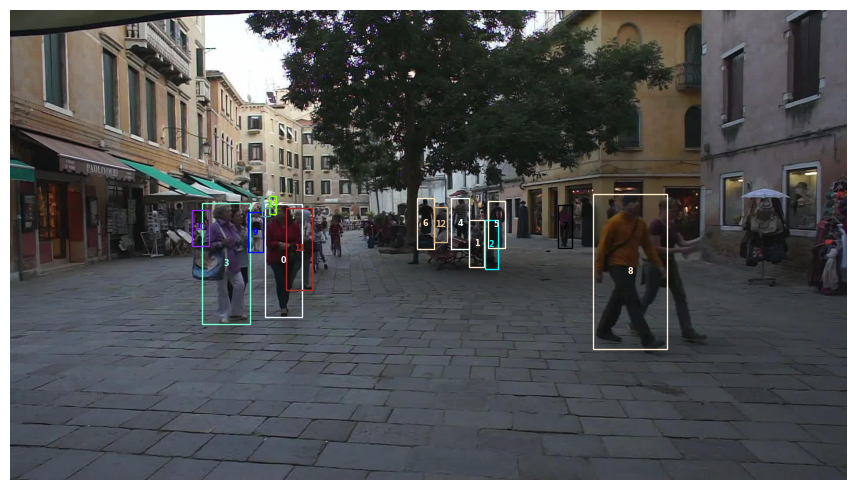

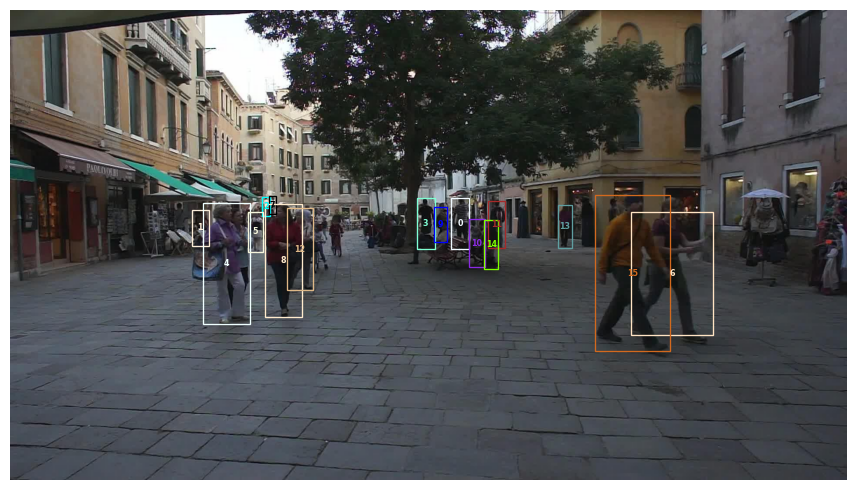

In [36]:
plot_sequence(
    results_seq["MOT16-02"],
    [s for s in val_sequences if str(s) == "MOT16-02"][0],
    first_n_frames=2,
)


# create gif

In [ ]:
seq_name =  "MOT16-02"
sequence = [s for s in val_sequences if str(s) == seq_name ][0]
tracker_seq_res = results_seq[seq_name]

In [15]:
frames = collect_frames_for_gif(sequence, tracker_seq_res)

100%|█████████████████████████████████████████| 600/600 [05:46<00:00,  1.73it/s]


In [18]:
gif.save(frames, 'MOT16-02_result_0001sec.gif', duration=0.001)